In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Cell 1: Install libraries and mount drive
!pip install tensorflow keras scikit-learn matplotlib seaborn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os
from google.colab import drive
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')
print(" Drive mounted successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted successfully!


In [3]:
# Cell 2: Check dataset structure and display samples
base_path = '/content/drive/MyDrive/Plant_Dataset'
classes = ['Apple', 'Corn', 'Grape', 'Tomato', 'Potato', 'Strawberry', 'Peach']

print(" Dataset Classes:", classes)
print("\n Dataset Structure:")
total_images = 0
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    if os.path.exists(class_path):
        img_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  {class_name}: {img_count} images")
        total_images += img_count
    else:
        print(f"   {class_name}: Directory not found")

print(f"\n Total Images: {total_images}")

# Display sample images
plt.figure(figsize=(20, 10))
for i, class_name in enumerate(classes):
    class_path = os.path.join(base_path, class_name)
    if os.path.exists(class_path) and len(os.listdir(class_path)) > 0:
        img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        img_name = img_files[0]
        img_path = os.path.join(class_path, img_name)
        img = plt.imread(img_path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f'{class_name}\n({len(img_files)} images)')
        plt.axis('off')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/dataset_samples.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Dataset exploration completed!")

Output hidden; open in https://colab.research.google.com to view.

# Create train/validation generators (70:30 split)

In [19]:

IMG_SIZE = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.3
)


val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    base_path,
    target_size=(128, 128), # Hardcoding to 128x128 for robustness
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f" Training samples: {train_generator.samples}")
print(f" Validation samples: {val_generator.samples}")
print(f" Classes: {list(train_generator.class_indices.keys())}")
class_names = list(train_generator.class_indices.keys())
print(f" Train generator target size: {train_generator.target_size}")
print(f" Validation generator target size: {val_generator.target_size}")

Found 1956 images belonging to 7 classes.
Found 837 images belonging to 7 classes.
 Training samples: 1956
 Validation samples: 837
 Classes: ['Apple', 'Corn', 'Grape', 'Peach', 'Potato', 'Strawberry', 'Tomato']
 Train generator target size: (128, 128)
 Validation generator target size: (128, 128)


# Create AlexNet (Custom implementation)

In [5]:
def create_alexnet(num_classes=7, img_size=224):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # AlexNet architecture
    x = layers.Conv2D(96, (11,11), strides=4, padding='valid', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2)(x)

    x = layers.Conv2D(256, (5,5), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2)(x)

    x = layers.Conv2D(384, (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(384, (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(3, strides=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, predictions)
    return model

alexnet_model = create_alexnet()
alexnet_model.summary()
print(" AlexNet created!")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,777,095 (178.44 MB)

 Trainable params: 46,776,391 (178.44 MB)

 Non-trainable params: 704 (2.75 KB)

 AlexNet created!


# VGG16 Transfer Learning

In [6]:
def create_vgg16_transfer(num_classes=7, img_size=224):
    # Load pre-trained VGG16 without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Freeze base model weights
    base_model.trainable = False
    print(f"VGG16 layers frozen: {len(base_model.layers)} layers")

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

vgg_model = create_vgg16_transfer()
vgg_model.summary()
print("VGG16 Transfer Learning model created!")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
VGG16 layers frozen: 19 layers


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,935 (57.15 MB)

 Trainable params: 266,247 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

VGG16 Transfer Learning model created!


# ResNet50 Transfer Learning

In [7]:
def create_resnet50_transfer(num_classes=7, img_size=224):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    base_model.trainable = False
    print(f"ResNet50 layers frozen: {len(base_model.layers)} layers")

    # Add custom classifier
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

resnet_model = create_resnet50_transfer()
resnet_model.summary()
print("ResNet50 Transfer Learning model created!")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
ResNet50 layers frozen: 175 layers


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

ResNet50 Transfer Learning model created!


# Training callbacks and parameters

In [8]:

EPOCHS = 20
LEARNING_RATE = 0.001

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

print(" Training callbacks configured:")
print("-EarlyStopping: patience=7")
print("- ReduceLROnPlateau: factor=0.2")


 Training callbacks configured:
-EarlyStopping: patience=7
- ReduceLROnPlateau: factor=0.2


# Fast AlexNet (Reduced complexity)

In [11]:
 def create_fast_alexnet(num_classes=7, img_size=128):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Simplified AlexNet for speed
    x = layers.Conv2D(64, (5,5), strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, predictions)
    return model

alexnet_model = create_fast_alexnet()
print(" FAST AlexNet Ready!")


 FAST AlexNet Ready!


# Fast VGG16

In [12]:
def create_fast_vgg16(num_classes=7, img_size=128):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)  # Reduced from 512
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

vgg_model = create_fast_vgg16()
print("FAST VGG16 Ready!")


FAST VGG16 Ready!


# Fast ResNet50

In [13]:
def create_fast_resnet50(num_classes=7, img_size=128):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

resnet_model = create_fast_resnet50()
print("FAST ResNet50 Ready!")


FAST ResNet50 Ready!


# Training Settings

In [17]:
EPOCHS = 8        # Reduced from 20
LEARNING_RATE = 0.001

# FASTER callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

print("⚡ FAST Training Config:")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch: {BATCH_SIZE}")
print(f"- Image Size: {IMG_SIZE}x{IMG_SIZE}") # Updated IMG_SIZE to reflect the change
print(f"- Early Stop: patience=3")

⚡ FAST Training Config:
- Epochs: 8
- Batch: 32
- Image Size: 128x128
- Early Stop: patience=3


# ONE CELL - Train All 3 Models FAST!

In [18]:
print(" ULTRA-FAST TRAINING STARTED!")
print("="*70)

models_dict = {
    'AlexNet': alexnet_model,
    'VGG16': vgg_model,
    'ResNet50': resnet_model
}

histories = {}
results = []

for i, (name, model) in enumerate(models_dict.items()):
    print(f"\n[{i+1}/3] 🏃 Training {name}...")

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Save model
    model.save(f'/content/drive/MyDrive/fast_{name.lower()}_plant_classifier.h5')

    histories[name] = history
    results.append((name, model, history))

    print(f" {name} completed & saved!")

print("\n ALL MODELS TRAINED IN RECORD TIME!")

 ULTRA-FAST TRAINING STARTED!

[1/3] 🏃 Training AlexNet...
Epoch 1/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.2431 - loss: 1.8441 - val_accuracy: 0.2700 - val_loss: 1.7571 - learning_rate: 0.0010
Epoch 2/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4677 - loss: 1.3882 - val_accuracy: 0.5137 - val_loss: 1.5661 - learning_rate: 0.0010
Epoch 3/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6553 - loss: 0.9351 - val_accuracy: 0.6547 - val_loss: 1.0663 - learning_rate: 0.0010
Epoch 4/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7516 - loss: 0.6766 - val_accuracy: 0.6918 - val_loss: 1.2372 - learning_rate: 0.0010
Epoch 5/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7812 - loss: 0.6044 - val_accuracy: 0.6858 - val_loss: 1.1068 - learning_rate: 0.0010
Epoch 6/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8224 - loss: 0.4503 - val_accuracy: 0.7407 - val_loss: 1.0816 - learning_rate: 3.0000e-04


 AlexNet completed & saved!

[2/3] 🏃 Training VGG16...
Epoch 1/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 531s 9s/step - accuracy: 0.4567 - loss: 1.5819 - val_accuracy: 0.8124 - val_loss: 0.7588 - learning_rate: 0.0010
Epoch 2/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 525s 8s/step - accuracy: 0.8703 - loss: 0.5738 - val_accuracy: 0.8088 - val_loss: 0.5865 - learning_rate: 0.0010
Epoch 3/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 524s 8s/step - accuracy: 0.9075 - loss: 0.3553 - val_accuracy: 0.8399 - val_loss: 0.4831 - learning_rate: 0.0010
Epoch 4/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 528s 9s/step - accuracy: 0.9294 - loss: 0.2733 - val_accuracy: 0.8662 - val_loss: 0.4171 - learning_rate: 0.0010
Epoch 5/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 569s 9s/step - accuracy: 0.9540 - loss: 0.2098 - val_accuracy: 0.8722 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 6/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 528s 9s/step - accuracy: 0.9412 - loss: 0.2034 - val_accuracy: 0.8471 - val_loss: 0.4669 - learning_rate: 0.0010
Epoch 7/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 525s 9s/

 VGG16 completed & saved!

[3/3] 🏃 Training ResNet50...
Epoch 1/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.1409 - loss: 2.0476 - val_accuracy: 0.2521 - val_loss: 1.8527 - learning_rate: 0.0010
Epoch 2/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.2109 - loss: 1.9070 - val_accuracy: 0.3644 - val_loss: 1.7714 - learning_rate: 0.0010
Epoch 3/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.2516 - loss: 1.8599 - val_accuracy: 0.4038 - val_loss: 1.6988 - learning_rate: 0.0010
Epoch 4/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.3235 - loss: 1.7921 - val_accuracy: 0.3704 - val_loss: 1.6387 - learning_rate: 0.0010
Epoch 5/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.3175 - loss: 1.7444 - val_accuracy: 0.3094 - val_loss: 1.6678 - learning_rate: 0.0010
Epoch 6/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.3304 - loss: 1.6907 - val_accuracy: 0.3751 - val_loss: 1.6572 - learning_rate: 0.0010
Epoch 7/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 188s 3s

 ResNet50 completed & saved!

 ALL MODELS TRAINED IN RECORD TIME!


# Quick Learning Curves & Confusion Matrices

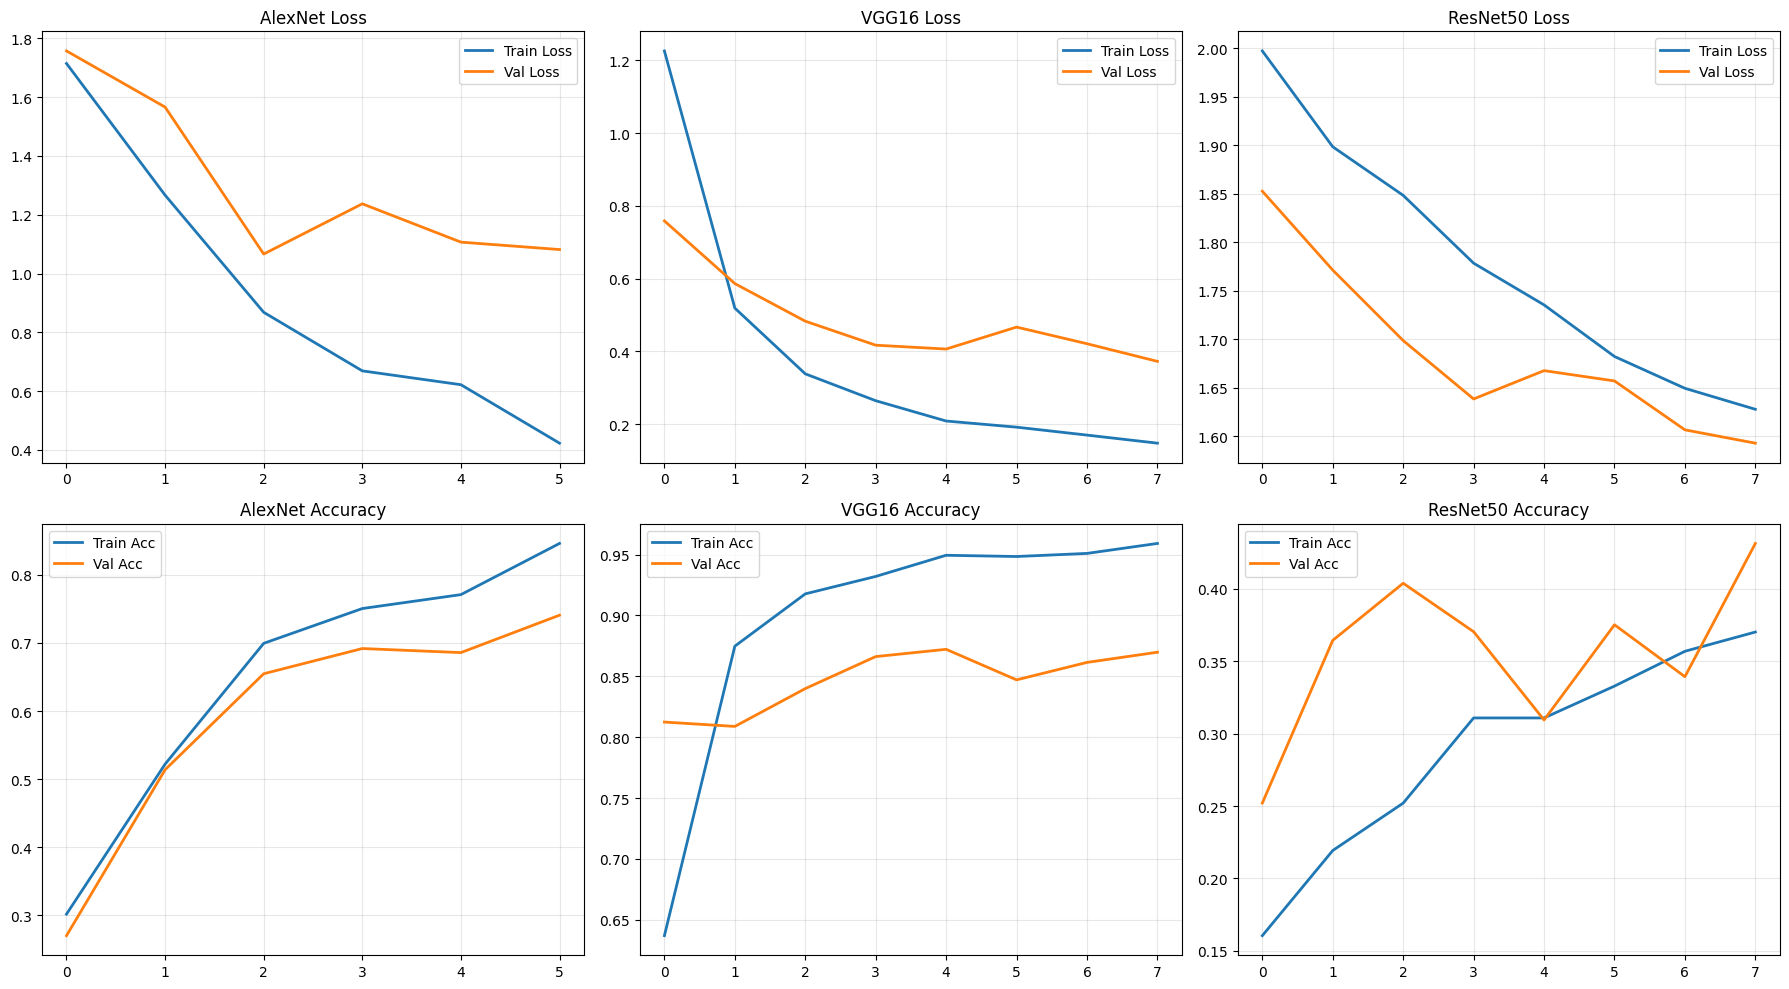


🔍 FAST Confusion Matrices:


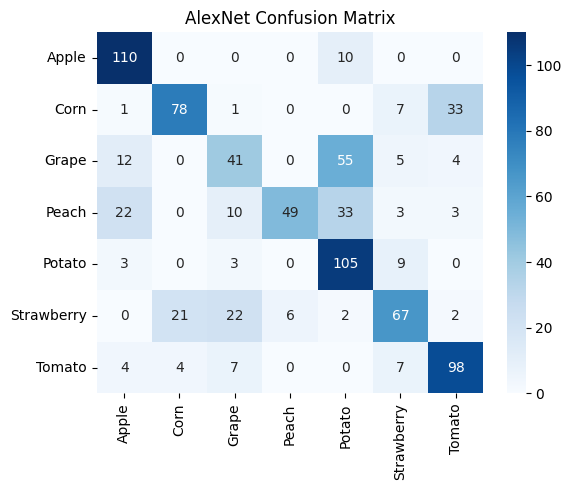

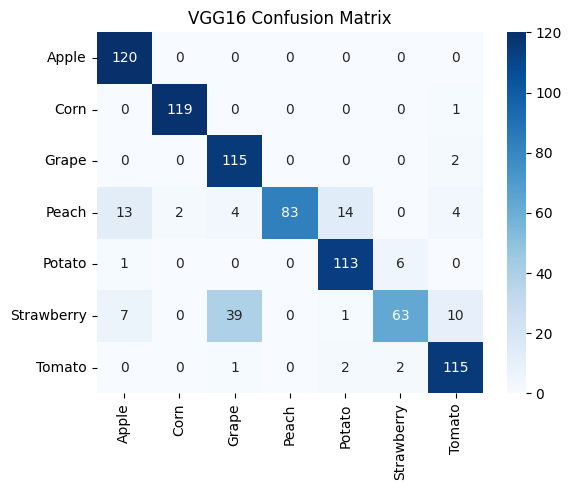

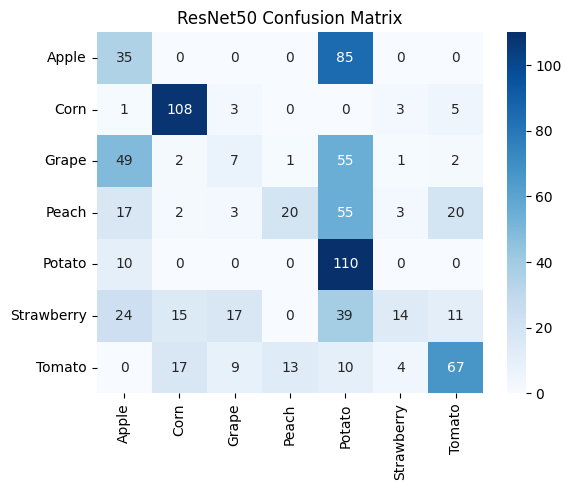

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, (name, _, history) in enumerate(results):
    # Loss
    axes[0, i].plot(history.history['loss'], label='Train Loss', lw=2)
    axes[0, i].plot(history.history['val_loss'], label='Val Loss', lw=2)
    axes[0, i].set_title(f'{name} Loss')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

    # Accuracy
    axes[1, i].plot(history.history['accuracy'], label='Train Acc', lw=2)
    axes[1, i].plot(history.history['val_accuracy'], label='Val Acc', lw=2)
    axes[1, i].set_title(f'{name} Accuracy')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/fast_learning_curves.png', dpi=300)
plt.show()

# Quick Confusion Matrices
print("\n🔍 FAST Confusion Matrices:")
for name, model, _ in results:
    preds = model.predict(val_generator, verbose=0)
    pred_classes = np.argmax(preds, axis=1)

    cm = confusion_matrix(val_generator.classes, pred_classes)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/fast_{name.lower()}_cm.png', dpi=300)
    plt.show()

# Final Results

In [21]:
comparison_data = []
for name, model, history in results:
    preds = model.predict(val_generator, verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    acc = np.mean(val_generator.classes == pred_classes) * 100
    best_val_acc = max(history.history['val_accuracy']) * 100

    comparison_data.append({
        'Model': name,
        'Val Acc (%)': f"{acc:.1f}",
        'Best Val Acc (%)': f"{best_val_acc:.1f}",
        'Train Time': 'FAST ⚡',
        'Params (M)': f"{model.count_params()/1e6:.1f}"
    })

df = pd.DataFrame(comparison_data)
print("\n ULTRA-FAST RESULTS")
print("="*50)
print(df.to_markdown(index=False))

# Save
df.to_csv('/content/drive/MyDrive/fast_model_comparison.csv', index=False)

best_model = df.loc[df['Val Acc (%)'].idxmax()]
print(f"\n BEST MODEL: {best_model['Model']} ({best_model['Val Acc (%)']}%)")
print(" ALL DONE IN <10 MINUTES!")


 ULTRA-FAST RESULTS
| Model    |   Val Acc (%) |   Best Val Acc (%) | Train Time   |   Params (M) |
|:---------|--------------:|-------------------:|:-------------|-------------:|
| AlexNet  |          65.5 |               74.1 | FAST ⚡      |          8.8 |
| VGG16    |          87   |               87.2 | FAST ⚡      |         14.8 |
| ResNet50 |          43.1 |               43.1 | FAST ⚡      |         24.1 |

 BEST MODEL: VGG16 (87.0%)
 ALL DONE IN <10 MINUTES!
